<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/Kalman_Filters_Math_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Filter: Mathematical Formulation

## 1. Problem Setup

The Kalman Filter estimates the **hidden state** $x_t$ of a system given **noisy observations** $z_t$.  

We assume a **linear Gaussian state-space model**.

### State Transition (Process Model)

$$
x_t = F x_{t-1} + B u_t + w_t
$$

- $x_t$ : hidden state vector at time \(t\)  
- $F$ : state transition matrix  
- $B u_t$ : optional control input (can be zero)  
- $w_t \sim \mathcal{N}(0, Q)$ : process noise  

### Observation Model

$$
z_t = H x_t + v_t
$$

- $z_t$ : observation vector at time $t$  
- $H$ : observation matrix  
- $v_t \sim \mathcal{N}(0, R)$ : measurement noise  

---

## 2. Kalman Filter Equations

### Prediction Step

$$
\hat{x}_{t|t-1} = F \hat{x}_{t-1|t-1} + B u_t
$$

$$
P_{t|t-1} = F P_{t-1|t-1} F^\top + Q
$$

### Update Step

$$
y_t = z_t - H \hat{x}_{t|t-1} \quad \text{(innovation)}
$$

$$
S_t = H P_{t|t-1} H^\top + R \quad \text{(innovation covariance)}
$$

$$
K_t = P_{t|t-1} H^\top S_t^{-1} \quad \text{(Kalman gain)}
$$

$$
\hat{x}_{t|t} = \hat{x}_{t|t-1} + K_t y_t
$$

$$
P_{t|t} = (I - K_t H) P_{t|t-1}
$$

---

## 3. Interpretation

- **Prediction step:** Forecast next state using the model  
- **Update step:** Correct forecast using observation  
- **Kalman gain $K_t$:** Balances trust between model and observation  

---

## 4. Example: 1D Stock Price with Trend

State vector:

$$
x_t =
\begin{bmatrix}
p_t \\ v_t
\end{bmatrix}
$$

- $p_t$ : true hidden price  
- $v_t$ : hidden trend (velocity)  

State transition:

$$
x_t =
\begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix} x_{t-1} + w_t
$$

Observation:

$$
z_t = [1 \quad 0] x_t + v_t
$$

- Only price is observed; trend is hidden  
- Process noise $w_t$ smooths the state  
- Measurement noise $v_t$ models observation error


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Simulate toy stock data
np.random.seed(42)
n_timesteps = 50
true_price = np.zeros(n_timesteps)
true_trend = 0.5
observed_price = np.zeros(n_timesteps)

true_price[0] = 10
observed_price[0] = true_price[0] + np.random.normal(0, 1)

for t in range(1, n_timesteps):
    true_price[t] = true_price[t-1] + true_trend
    observed_price[t] = true_price[t] + np.random.normal(0, 1)  # noisy observation

In [3]:
# Define Kalman Filter parameters

# State vector: [price, trend]
F = np.array([[1, 1],
              [0, 1]])   # Price = Price + Trend, Trend = Trend
H = np.array([[1, 0]])    # We only observe price

Q = np.array([[1e-5, 0],
              [0, 1e-5]])  # Process noise
R = np.array([[1]])        # Observation noise

x_est = np.array([observed_price[0], 0])  # initial state estimate
P = np.eye(2)                             # initial covariance

# Storage
x_estimates = np.zeros((n_timesteps, 2))
P_estimates = np.zeros((n_timesteps, 2, 2))

In [4]:
# Kalman Filter Loop

for t in range(n_timesteps):
    # 1. Predict
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q

    # 2. Update
    z = observed_price[t]
    y = z - (H @ x_pred)              # innovation
    S = H @ P_pred @ H.T + R          # innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain

    x_est = x_pred + K.flatten() * y
    P = (np.eye(2) - K @ H) @ P_pred

    # Store
    x_estimates[t] = x_est
    P_estimates[t] = P

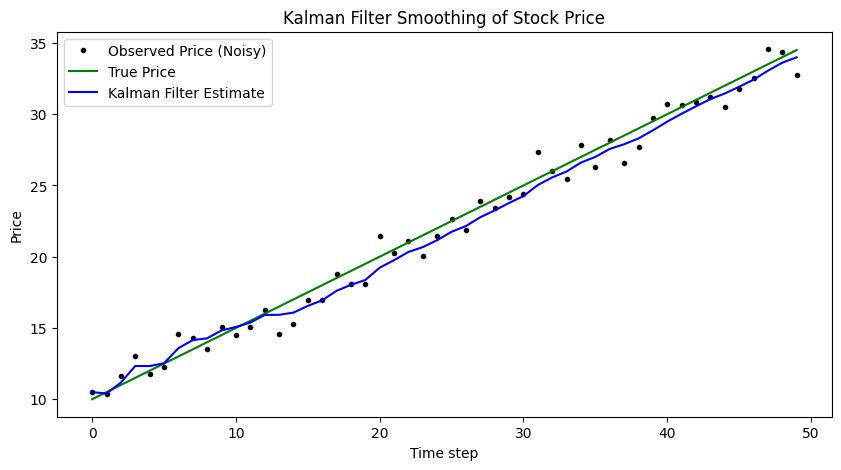

In [5]:
# Plot results

plt.figure(figsize=(10,5))
plt.plot(observed_price, 'k.', label='Observed Price (Noisy)')
plt.plot(true_price, 'g-', label='True Price')
plt.plot(x_estimates[:,0], 'b-', label='Kalman Filter Estimate')
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Price")
plt.title("Kalman Filter Smoothing of Stock Price")
plt.show()

# Kalman Filter for Stock Price and Trend Estimation

This code snippet demonstrates how to apply a Kalman Filter to estimate the true price and underlying trend (velocity) of a stock using noisy observed prices.

## Overview

The Kalman Filter is a recursive algorithm that estimates the state of a dynamic system from a series of noisy measurements. In this example, we model the stock price and its trend as a linear system with Gaussian noise and use the Kalman Filter to smooth the observed price data and estimate the hidden trend.

## Code Description

1. **Import Libraries:** Imports necessary libraries: `numpy` for numerical operations, `matplotlib` for plotting, and `yfinance` to download stock data.
2. **Download Stock Data:** Downloads historical stock data for a specified ticker (default is MSFT) and date range using `yfinance`. It extracts the closing prices and corresponding dates.
3. **Define Kalman Filter Parameters:**
   - `F`: State transition matrix. Models how the state (price and trend) evolves over time. Here, it assumes the price at the next time step is the current price plus the current trend, and the trend remains constant.
   - `H`: Observation matrix. Defines how the hidden state is observed. Here, we only observe the price.
   - `Q`: Process noise covariance matrix. Represents the uncertainty in the state transition model.
   - `R`: Observation noise covariance matrix. Represents the uncertainty in the price observations.
4. **Initialize State and Covariance:**
   - `x_est`: Initial estimate of the state vector (price and trend). It's initialized with the first observed price and a trend of zero.
   - `P`: Initial estimate of the state covariance matrix, representing the uncertainty in the initial state estimate.
5. **Kalman Filter Loop:** Iterates through the observed prices and applies the two main steps of the Kalman Filter:
   - **Predict:** Predicts the next state and its covariance based on the previous state estimate and the state transition model.
   - **Update:** Corrects the predicted state and covariance using the current observation, the observation model, and the Kalman gain. The Kalman gain determines how much the observation influences the state update.
6. **Store Estimates:** Stores the estimated state (price and trend) and covariance at each time step.
7. **Plot Results:** Plots the observed price, the Kalman Filter's estimated price, and the estimated trend over time.


/tmp/ipython-input-3302746002.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("MSFT", start="2023-01-01", end="2025-06-01")
[*********************100%***********************]  1 of 1 completed


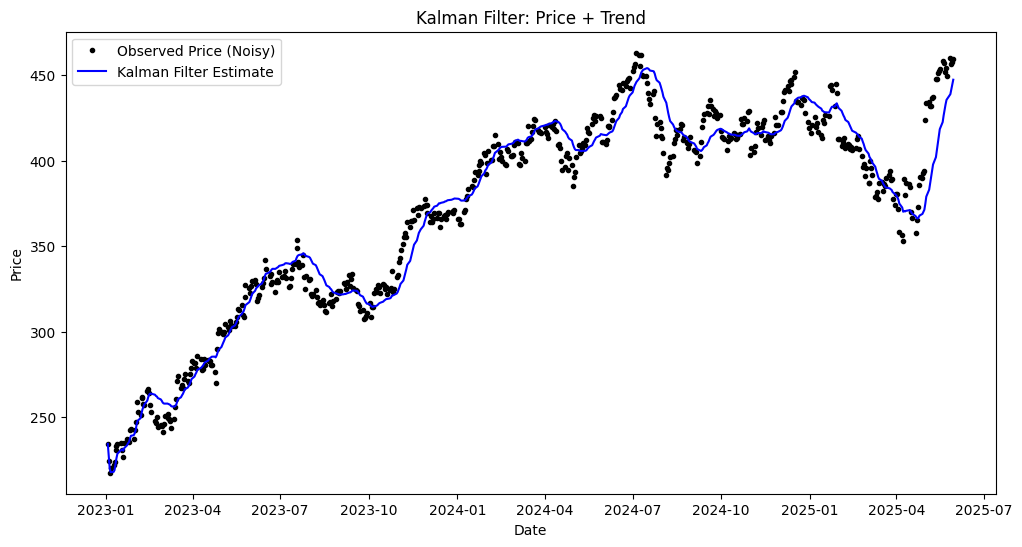

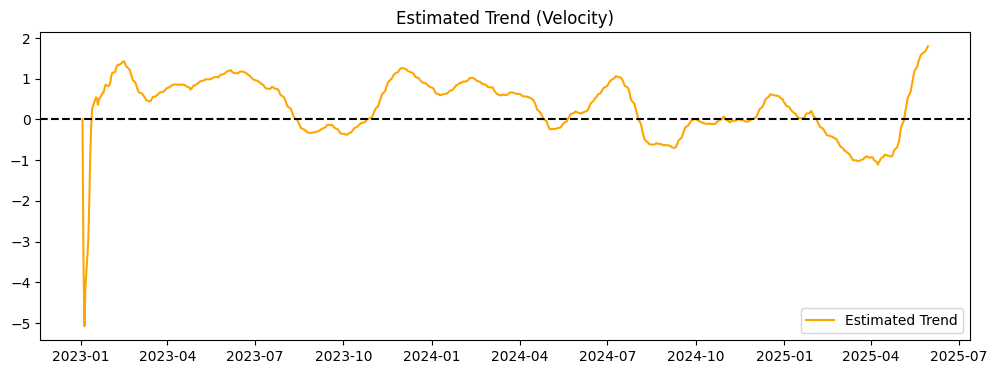

In [6]:
import yfinance as yf

data = yf.download("MSFT", start="2023-01-01", end="2025-06-01")
prices = data["Close"].to_numpy(dtype=float).flatten()
dates = data.index
n_timesteps = len(prices)


# Define Kalman Filter parameters

# State vector: [price, trend]
F = np.array([[1, 1],
              [0, 1]])   # Price = Price + Trend, Trend = Trend
H = np.array([[1, 0]])    # Observe only price

Q = np.array([[1e-5, 0],
              [0, 1e-5]])  # Process noise
R = np.array([[1]])        # Observation noise

# Initialize state and covariance
x_est = np.array([prices[0], 0.0])  # initial state: first price, zero trend
P = np.eye(2)                        # initial covariance

# Storage for estimates
x_estimates = np.zeros((n_timesteps, 2))
P_estimates = np.zeros((n_timesteps, 2, 2))


# Kalman Filter Loop

for t in range(n_timesteps):
    # 1. Predict
    x_pred = F @ x_est
    P_pred = F @ P @ F.T + Q

    # 2. Update
    z = prices[t]
    y = z - (H @ x_pred)            # innovation
    S = H @ P_pred @ H.T + R        # innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain

    x_est = x_pred + K.flatten() * y
    P = (np.eye(2) - K @ H) @ P_pred

    # Store
    x_estimates[t] = x_est
    P_estimates[t] = P


# Plot results
# -----------------------
plt.figure(figsize=(12,6))
plt.plot(dates, prices, 'k.', label='Observed Price (Noisy)')
plt.plot(dates, x_estimates[:,0], 'b-', label='Kalman Filter Estimate')
plt.title('Kalman Filter: Price + Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
# -------------------------------
plt.figure(figsize=(12,4))
plt.plot(dates, x_estimates[:,1], 'orange', label='Estimated Trend')
plt.axhline(0, color='black', linestyle='--')
plt.title('Estimated Trend (Velocity)')
plt.legend()
plt.show()
